# Pseudotime using spectral embedding

In [1]:
%matplotlib inline
import numpy as np
from numpy.matlib import repmat
from matplotlib import pyplot as plt
import pandas as pd
from OscopeBootstrap.pseudotime import estimate_pseudotime_using_spectral_embedding, calculate_metrics, \
    plot_latent_space, plot_gene_fits, plot_correspondence_of_peaktime_and_times

## Load data

In [2]:
path_to_results = '../casestudy/Whitfield/Results'
netresults = pd.read_csv(f'{path_to_results}/filt0.9Data_N2000_g50_TFTrue_SummaryPartition.csv', index_col=[0])
data = pd.read_csv(f'{path_to_results}/filt0.9Data.txt', index_col=[0], sep=None)
commData = pd.read_csv(f'{path_to_results}/witfildCommG50.txt', sep=None)
commDataCC = pd.read_csv(f'{path_to_results}/CCwitfildCommG50.txt', sep=None)

/Users/mqbssaby/pythonprojects/FullOscoNet/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mqbssaby/pythonprojects/FullOscoNet/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/Users/mqbssaby/pythonprojects/FullOscoNet/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  """


Get community of interest

In [3]:
# get cluster 265 genes, 239 are CC
commId = 124 # community to look at
comm = commData[commData.CommunityID == commId][['CloneID', 'GeneSymbol']]
assert comm.shape[0] == 265, comm.shape

### Calculate grount truth pseudotime time


In [4]:
ptTruePeriod = repmat(np.arange(15), 1, 4).flatten()[:48]
assert ptTruePeriod.size == 48, 'number of time points must be 48'

### Load ENI results

In [5]:
enid = '_30k'
clusterENI = {}
for i in range(1, 4):
    cloneids = pd.read_csv(f'{path_to_results}/OscopeClusterC%i%s.csv' % (i, enid), index_col=[0])
    eniIndex = pd.read_csv(f'{path_to_results}/OscopeClusterC%iENI%s.csv' % (i, enid), index_col=[0])
    eni=(eniIndex-1) / (eniIndex-1).max()
    clusterENI['cluster%g' % i] = {'pt': eni.values.flatten(), 'cloneid': cloneids}

## Select cluster
1. Results using 72 gene cluster (Figure 5 (a))
1. Results using 265 gene cluster (Figure 5 (b))

You can modify `geneplot` to plot other genes

In [6]:
config = 2
if config == 1:
    resultsTraining = 'cluster1'
    resultsTest = 'cluster1'
    n_neighbors = 33
else:
    resultsTraining = 'cluster3'
    resultsTest = 'cluster1'
    n_neighbors = 31
assert resultsTraining in ['cluster1', 'cluster3']
assert resultsTest in ['cluster1', 'cluster3']
geneplot = ['PLK', 'CCNE1', 'CDC6']

Get data for given cluster

In [7]:
cloneidlist = clusterENI[resultsTraining]['cloneid'].values.flatten()
cloneidlistEval = clusterENI[resultsTest]['cloneid'].values.flatten()  # use just cluster 1 genes for evaluation
training_data = data.loc[cloneidlist, :].values.T

### look at fits using the true time (ptTruePeriod)

peak R=1.00 pseudotime - true roughness 0.00 corr pseudotime 1.00, ks=0.92


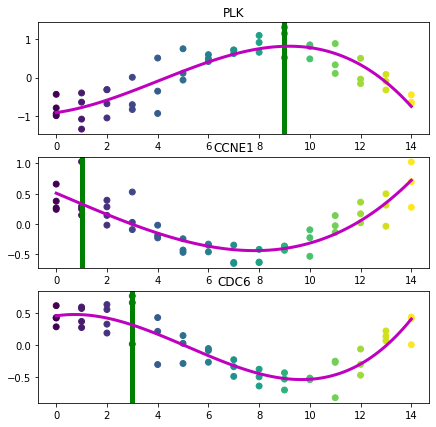

In [8]:
metrics_true = calculate_metrics(data, commData, cloneidlistEval, ptTruePeriod, ptTruePeriod)
_ = plot_gene_fits(geneplot, data, cloneidlistEval, commData, ptTruePeriod, ptTruePeriod)

### spectral method


peak R=0.99 pseudotime - true roughness -0.19 corr pseudotime 0.64, ks=0.09


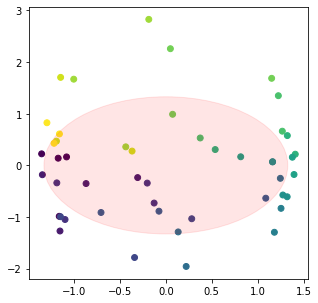

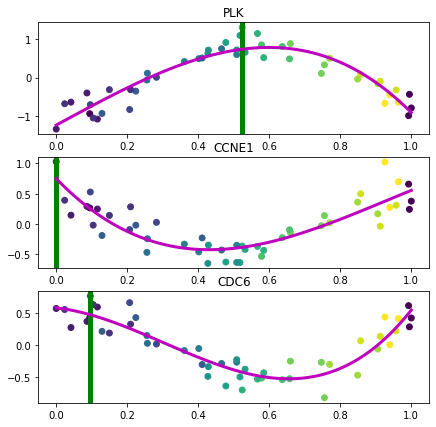

In [9]:
pt_spectral, latent_space_2d = estimate_pseudotime_using_spectral_embedding(training_data, n_neighbors)
metrics_spectral = calculate_metrics(data, commData, cloneidlistEval, pt_spectral, ptTruePeriod)
_ = plot_latent_space(latent_space_2d, ptTruePeriod)
_ = plot_gene_fits(geneplot, data, cloneidlistEval, commData, pt_spectral, ptTruePeriod)

### ENI pseudotime method

peak R=-0.19 pseudotime - true roughness 0.56 corr pseudotime -0.05, ks=0.02


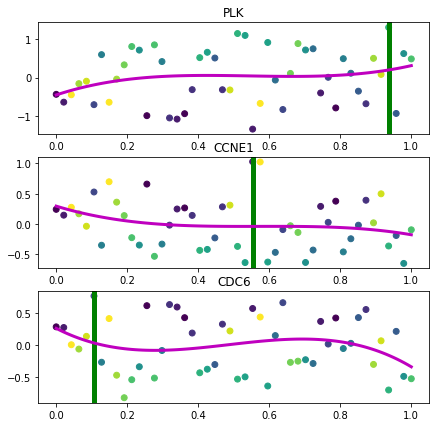

In [10]:
ptENI = clusterENI[resultsTraining]['pt']
metrics_eni = calculate_metrics(data, commData, cloneidlistEval, ptENI, ptTruePeriod)
_ = plot_gene_fits(geneplot, data, cloneidlistEval, commData, ptENI, ptTruePeriod)